In [2]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import plotly.express as px
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark import SparkFiles
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

In [3]:
spark = SparkSession.builder.appName("ProjetoABD_parte2").getOrCreate()

In [4]:
dados = spark.read.load('avioes/tudo_junto/ok2/dados.csv',format='csv',sep=',',inferSchema=True, header=True).limit(1000000)

In [4]:
dados.printSchema()
dados.show()
dados.count()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true

1000000

In [ ]:
dados = dados.withColumn("Tem_DepDelay",
                         F.when(dados["DepDelay"]>15,1).otherwise(0))

dados = dados.withColumn("Tem_ArrDelay",
                         F.when(dados["ArrDelay"]>5,1).otherwise(0))

In [6]:
dados.printSchema()
dados.show()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true

## ArrDelay

In [ ]:

categorical_cols = [
    "Operated_or_Branded_Code_Share_Partners",
    "Operating_Airline",
    "Origin",
    "Dest",
    "OriginCityNameState",
    "DestCityNameState"
]

numeric_cols = [
    "Year", "Quarter", "Month", "DayOfWeek", "Flight_Number_Operating_Airline",
    "CRSDepTime", "DepTime", "TaxiOut", "WheelsOff", "Distance", "DistanceGroup",
    "AirTime", 
    #"CRSArrTime", "ArrTime",
    "WheelsOn", "TaxiIn", "CRSElapsedTime", 
    "ActualElapsedTime"
]

indexers = [StringIndexer(inputCol=c, outputCol=c + "_Index", handleInvalid="keep") for c in categorical_cols]
all_features = numeric_cols + [c + "_Index" for c in categorical_cols]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")

In [ ]:

rf = RandomForestClassifier(labelCol="Tem_ArrDelay", featuresCol="features",maxBins=512)


pipeline = Pipeline(stages=indexers + [assembler, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [10, 15]) \
    .build()


evaluator = MulticlassClassificationEvaluator(
    labelCol="Tem_ArrDelay", 
    predictionCol="prediction", 
    metricName="accuracy"
)


tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,# 80/20
    parallelism=1     # Prevents memory blowup
)


model = tvs.fit(dados)

In [ ]:

predictions = model.transform(dados)


predictions_cast = predictions.withColumn("prediction", predictions["prediction"].cast("float")) \
                              .withColumn("Tem_ArrDelay", predictions["Tem_ArrDelay"].cast("float"))


predictionAndLabels = predictions_cast.select("prediction", "Tem_ArrDelay").rdd.map(tuple)


/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[721451.   7634.]
 [136245. 134670.]]


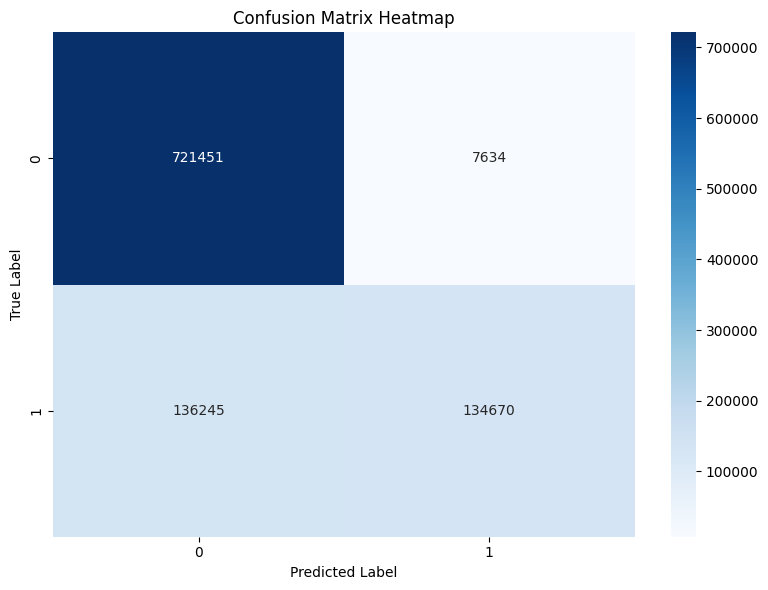

In [ ]:

metrics = MulticlassMetrics(predictionAndLabels)
conf_matrix = metrics.confusionMatrix().toArray()
print(conf_matrix)

labels = sorted(set(predictionAndLabels.map(lambda x: x[1]).distinct().collect()))

class_labels = [int(label) for label in labels]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

In [8]:
for label in labels:
    print(f"Class {int(label)}:")
    print(f"  Precision = {metrics.precision(label):.2f}")
    print(f"  Recall    = {metrics.recall(label):.2f}")
    print(f"  F1 Score  = {metrics.fMeasure(label):.2f}")


Class 0:
  Precision = 0.84
  Recall    = 0.99
  F1 Score  = 0.91
Class 1:
  Precision = 0.95
  Recall    = 0.50
  F1 Score  = 0.65


In [ ]:
print(f"Weighted Precision = {metrics.weightedPrecision:.2f}")
print(f"Weighted Recall    = {metrics.weightedRecall:.2f}")
print(f"Weighted F1 Score  = {metrics.weightedFMeasure():.2f}")

Weighted Precision = 0.87
Weighted Recall    = 0.86
Weighted F1 Score  = 0.84


In [10]:
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="Tem_ArrDelay", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
auc = binary_evaluator.evaluate(predictions)
print(f"AUC: {auc:.3f}")

AUC: 0.939


In [11]:
rf_model = model.bestModel.stages[-1]  # Assuming RF is last stage
importances = rf_model.featureImportances

# Match with feature names
features = assembler.getInputCols()
feature_importance = sorted(zip(features, importances), key=lambda x: -x[1])
for feat, imp in feature_importance[:10]:  # top 10
    print(f"{feat}: {imp:.4f}")


CRSDepTime: 0.2414
TaxiOut: 0.1603
WheelsOff: 0.1068
DepTime: 0.1019
WheelsOn: 0.0851
TaxiIn: 0.0536
CRSElapsedTime: 0.0310
Dest_Index: 0.0298
Origin_Index: 0.0291
OriginCityNameState_Index: 0.0288


## DepDelay

In [ ]:

categorical_cols = [
    "Operated_or_Branded_Code_Share_Partners",
    "Operating_Airline",
    "Origin",
    "Dest",
    "OriginCityNameState",
    "DestCityNameState"
]

numeric_cols = [
    "Year", "Quarter", "Month", "DayOfWeek", "Flight_Number_Operating_Airline",
    #"CRSDepTime", "DepTime", 
    "TaxiOut", "WheelsOff", "Distance", "DistanceGroup","AirTime", 
    "CRSArrTime", "ArrTime",
    "WheelsOn", "TaxiIn", "CRSElapsedTime", 
    "ActualElapsedTime"
]

indexers = [StringIndexer(inputCol=c, outputCol=c + "_Index", handleInvalid="keep") for c in categorical_cols]
all_features = numeric_cols + [c + "_Index" for c in categorical_cols]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")

In [7]:

rf = RandomForestClassifier(labelCol="Tem_DepDelay", featuresCol="features",maxBins=512)


pipeline = Pipeline(stages=indexers + [assembler, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [10, 15]) \
    .build()


evaluator = MulticlassClassificationEvaluator(
    labelCol="Tem_DepDelay", 
    predictionCol="prediction", 
    metricName="accuracy"
)

tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,   # 80% train, 20% validation
    parallelism=1     # Prevents memory blowup
)


model = tvs.fit(dados)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/IPyt

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# Now safe to evaluate
metrics = MulticlassMetrics(predictionAndLabels)
conf_matrix = metrics.confusionMatrix().toArray()
print(conf_matrix)

labels = sorted(set(predictionAndLabels.map(lambda x: x[1]).distinct().collect()))
# Optional: class labels from the model (can also be [0, 1, 2, ...])
class_labels = [int(label) for label in labels]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
for label in labels:
    print(f"Class {int(label)}:")
    print(f"Precision = {metrics.precision(label):.2f}")
    print(f"Recall    = {metrics.recall(label):.2f}")
    print(f"F1 Score  = {metrics.fMeasure(label):.2f}")

In [ ]:
print(f"Weighted Precision = {metrics.weightedPrecision:.2f}")
print(f"Weighted Recall    = {metrics.weightedRecall:.2f}")
print(f"Weighted F1 Score  = {metrics.weightedFMeasure():.2f}")

In [ ]:
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="Tem_DepDelay", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
auc = binary_evaluator.evaluate(predictions)
print(f"AUC: {auc:.3f}")

In [ ]:
rf_model = model.bestModel.stages[-1]  # Assuming RF is last stage
importances = rf_model.featureImportances

# Match with feature names
features = assembler.getInputCols()
feature_importance = sorted(zip(features, importances), key=lambda x: -x[1])
for feat, imp in feature_importance[:10]:  # top 10
    print(f"{feat}: {imp:.4f}")
